Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__alpha,mean_test_score,std_test_score
1,1.0,0.778964,0.006679
0,0.1,0.777685,0.007173


NB
accuracy 0.8481442133040885
f1_macro 0.778916147185104


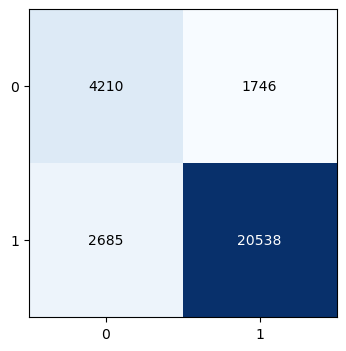

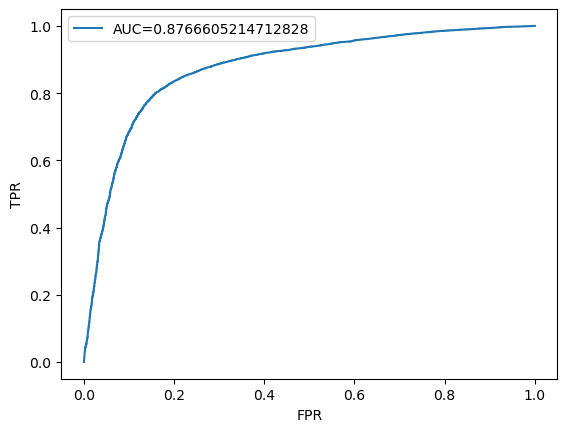

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
1,1.0,0.792097,0.006849
0,0.5,0.788328,0.006222


LR
accuracy 0.8480071284142705
f1_macro 0.7920728830703705


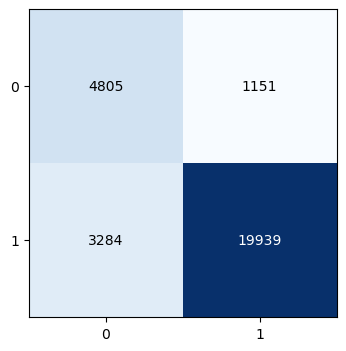

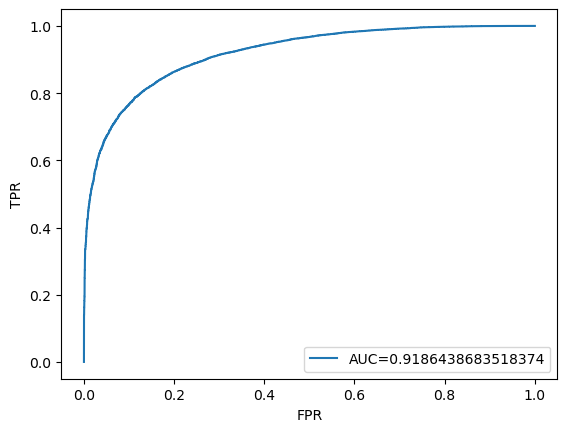

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.783762,0.008877
1,1.0,0.776620,0.005205


SVM
accuracy 0.8461564824017273
f1_macro 0.7837386644316803


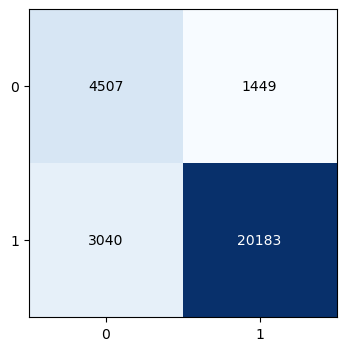

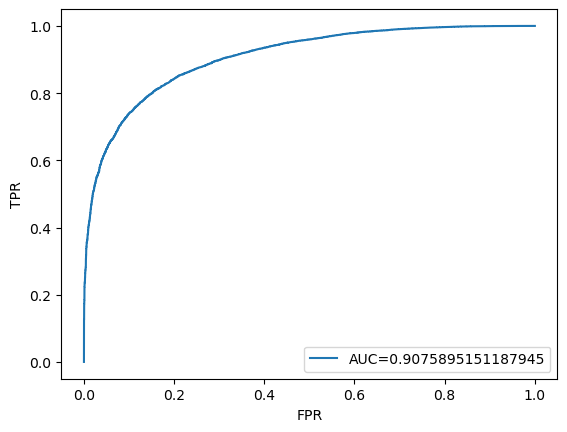

In [4]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.special import expit
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.metrics import (accuracy_score,confusion_matrix, f1_score, roc_auc_score, roc_curve, auc)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

warnings.filterwarnings("ignore", category=FutureWarning)

warnings.filterwarnings("ignore", category=FutureWarning)


URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")
HTML_PATTERN = re.compile(r"<.*?>")
ALLOWED_CHARS = re.compile(r"[^a-z0-9\.\!\?\'\s]")
CONTRACTIONS = {"can't":"cannot","won't":"will not","n't":" not","'re":" are","'s":" is","'d":" would","'ll":" will","'ve":" have","'m":" am"}
NEG_CUES = {"not","never","no","n't","cannot"}
STOPWORDS = {"the","and","a","an","of","in","on","at","to","is","it","this","that","i","you","he","she","they","we","was","were","be","been","am","are","but","if","or","as","with","for","not","no","so","too","very"}

def expand_contractions(t):
    for p,r in CONTRACTIONS.items():
        t = re.sub(p,r,t)
    return t

def basic_clean(t):
    t = expand_contractions(t.lower())
    t = HTML_PATTERN.sub(" ",t)
    t = URL_PATTERN.sub(" ",t)
    t = ALLOWED_CHARS.sub(" ",t)
    return re.sub(r"\s+"," ",t).strip()

def clean_series(s):
    return s.astype(str).fillna("").map(basic_clean)

def mark_negations(s):
    out = []
    for txt in s:
        neg = False
        buf = []
        for tok in txt.split():
            if tok in NEG_CUES:
                buf.append(f"{tok}_NEG")
                neg = True
            elif neg and re.fullmatch(r"[a-z0-9']+",tok):
                buf.append(f"{tok}_NEG")
            else:
                buf.append(tok)
                if re.search(r"[\.\!\?]$",tok):
                    neg = False
        out.append(" ".join(buf))
    return pd.Series(out,index=s.index)

def remove_stopwords(s):
    return s.map(lambda t:" ".join(w for w in t.split() if len(w)>1 and w not in STOPWORDS))

def show_cv_table(res, cols):
    df = pd.DataFrame(res)
    param_cols = [f"param_{c}" for c in cols]
    tbl = df[param_cols + ["mean_test_score", "std_test_score"]]
    tbl = tbl.rename(columns=dict(zip(param_cols, cols)))
    display(tbl.sort_values("mean_test_score", ascending=False))


def evaluate_model(y_true,y_pred,y_prob,name):
    print(name)
    print("accuracy",accuracy_score(y_true,y_pred))
    print("f1_macro",f1_score(y_true,y_pred,average="macro"))
    cm = confusion_matrix(y_true,y_pred)
    plt.figure(figsize=(4,4)); plt.imshow(cm,cmap="Blues"); plt.xticks([0,1]); plt.yticks([0,1])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]),ha="center",va="center",color="white" if cm[i,j]>cm.max()/2 else "black")
    plt.show()
    fpr,tpr,_ = roc_curve(y_true,y_prob)
    plt.figure(); plt.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.show()

def run_cv(build_fn,X,y):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipes,grids = build_fn()
    best_models = {}
    scores = {}
    for name,pipe in pipes.items():
        gs = GridSearchCV(pipe,grids[name],cv=cv,scoring="f1_macro",n_jobs=-1,verbose=1)
        gs.fit(X,y)
        show_cv_table(gs.cv_results_,list(grids[name].keys()))
        best_models[name] = gs.best_estimator_
        if name == "SVM":
            scr = cross_val_predict(best_models[name],X,y,cv=cv,method="decision_function")
            preds = (scr >= 0).astype(int)
            probs = expit(scr)
        else:
            preds = cross_val_predict(best_models[name],X,y,cv=cv,method="predict")
            probs = cross_val_predict(best_models[name],X,y,cv=cv,method="predict_proba")[:,1]
        evaluate_model(y,preds,probs,name)
        scores[name] = f1_score(y,preds,average="macro")
    best_name = max(scores,key=scores.get)
    return best_models[best_name]

def load_data_fp():
    tr = pd.read_csv("train1.csv").drop_duplicates()
    te = pd.read_csv("test1.csv").drop_duplicates()
    tr["combined"] = tr["reviewText"].fillna("")+" "+tr["summary"].fillna("")
    te["combined"] = te["reviewText"].fillna("")+" "+te["summary"].fillna("")
    tr = tr[tr["combined"].str.len()>10].reset_index(drop=True)
    X_tr = remove_stopwords(mark_negations(clean_series(tr["combined"])))
    X_te = remove_stopwords(mark_negations(clean_series(te["combined"])))
    y = (tr["overall"]>1).astype(int).values
    ids = te["id"].tolist()
    return X_tr.tolist(), X_te.tolist(), y, ids

def build_pipelines_fp():
    cnt = CountVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,binary=True)
    tfd = TfidfVectorizer(max_features=10000,ngram_range=(1,2),stop_words="english",min_df=3,max_df=0.7,sublinear_tf=True)
    pipe_nb = Pipeline([("vect",cnt),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("vect",tfd),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=300))])
    pipe_svm = Pipeline([("vect",TfidfVectorizer(stop_words="english",lowercase=True,max_df=0.8,min_df=3,sublinear_tf=True,ngram_range=(1,2),max_features=10000)),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,1]},"LR":{"clf__C":[0.5,1]},"SVM":{"clf__C":[0.5,1]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_fp()
    best_model = run_cv(build_pipelines_fp,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("text1_output1.csv",index=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__alpha,mean_test_score,std_test_score
1,0.5,0.812827,0.003587
0,0.1,0.810969,0.001985
2,1.0,0.786331,0.003565


NB
accuracy 0.8253794237555243
f1_macro 0.812837495458653


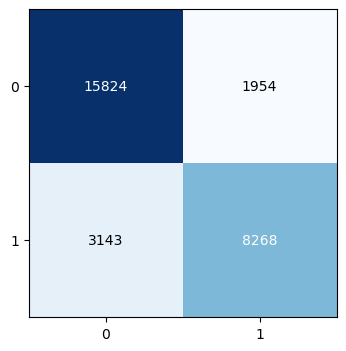

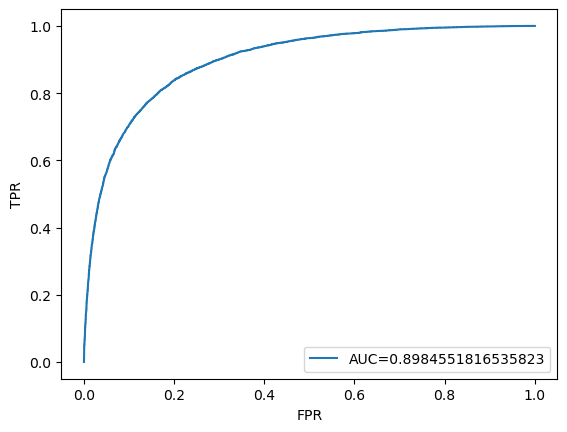

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
2,2.0,0.833804,0.003452
1,1.0,0.832425,0.003844
0,0.5,0.828008,0.003548


LR
accuracy 0.8399054438315804
f1_macro 0.8338056938688951


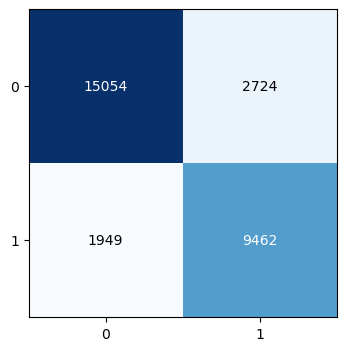

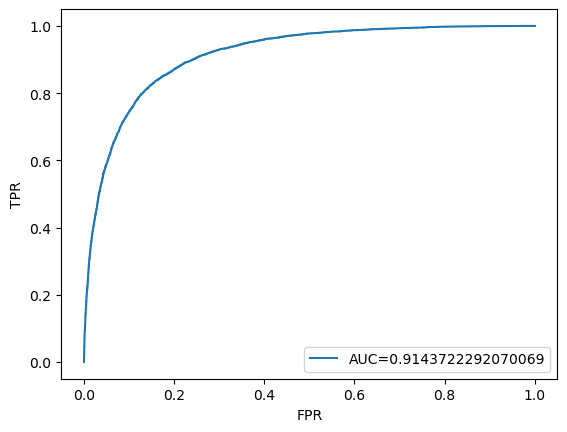

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.828444,0.003335
1,1.0,0.822012,0.003219
2,2.0,0.813848,0.003818


SVM
accuracy 0.8350063380040427
f1_macro 0.8284435448432195


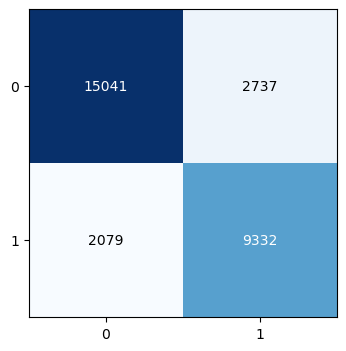

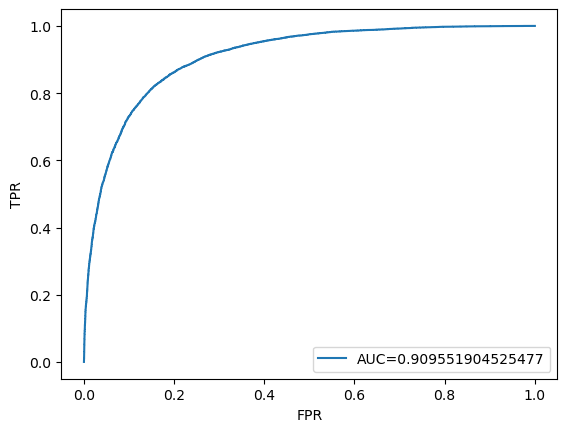

In [7]:
def load_data_mid():
    tr = pd.read_csv("train1.csv").drop_duplicates()
    te = pd.read_csv("test1.csv").drop_duplicates()
    for df in (tr,te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
        df["verified"] = df["verified"].fillna(False).astype(int)
        df["vote"] = pd.to_numeric(df["vote"].astype(str).str.replace(",",""),errors="coerce").fillna(0.0)
    y = (tr["overall"]>3).astype(int).values
    ids = te["id"].tolist()
    return tr.drop(columns=["overall"]), te, y, ids

def preprocessor_mid():
    tfidf_review = TfidfVectorizer(max_features=60000,ngram_range=(1,2),stop_words="english",min_df=3,sublinear_tf=True)
    tfidf_summary = TfidfVectorizer(max_features=15000,ngram_range=(1,1),stop_words="english",min_df=2,sublinear_tf=True)
    tfidf_category = TfidfVectorizer(analyzer="char",ngram_range=(3,5),min_df=1)
    return ColumnTransformer([
        ("review",tfidf_review,"reviewText"),
        ("summary",tfidf_summary,"summary"),
        ("category",tfidf_category,"category"),
        ("verified",OneHotEncoder(handle_unknown="ignore"),["verified"]),
        ("vote",FunctionTransformer(func=np.log1p,validate=False,feature_names_out="one-to-one"),["vote"])
    ],remainder="drop",sparse_threshold=0.3)

def build_pipelines_mid():
    feat = preprocessor_mid()
    pipe_nb = Pipeline([("feat",feat),("clf",MultinomialNB())])
    pipe_lr = Pipeline([("feat",feat),("clf",LogisticRegression(class_weight="balanced",solver="liblinear",max_iter=2000))])
    pipe_svm = Pipeline([("feat",feat),("clf",LinearSVC(class_weight="balanced",max_iter=3000))])
    grids = {"NB":{"clf__alpha":[0.1,0.5,1.0]},"LR":{"clf__C":[0.5,1.0,2.0]},"SVM":{"clf__C":[0.5,1.0,2.0]}}
    return {"NB":pipe_nb,"LR":pipe_lr,"SVM":pipe_svm},grids

if __name__ == "__main__":
    X_tr,X_te,y,ids = load_data_mid()
    best_model = run_cv(build_pipelines_mid,X_tr,y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id":ids,"overall":preds}).to_csv("test1_output2.csv",index=False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__alpha,mean_test_score,std_test_score
0,0.1,0.772344,0.012756
1,0.5,0.697770,0.012079
2,1.0,0.621439,0.009843


NB
accuracy 0.8673815478433656
f1_macro 0.7724714848213485


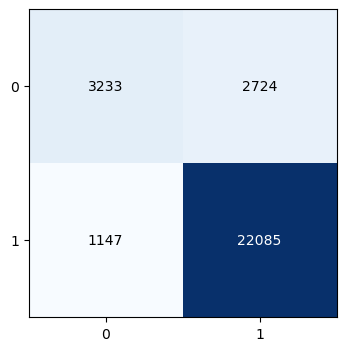

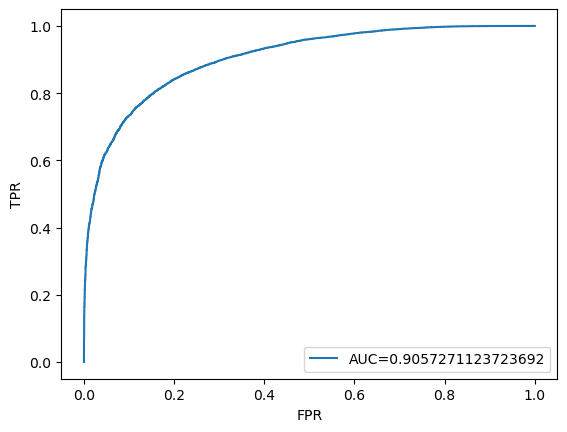

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
2,2.0,0.793136,0.006843
1,1.0,0.790987,0.005742
0,0.5,0.787988,0.006582


LR
accuracy 0.8559388810853403
f1_macro 0.7931694188416456


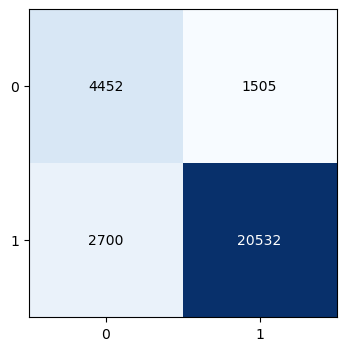

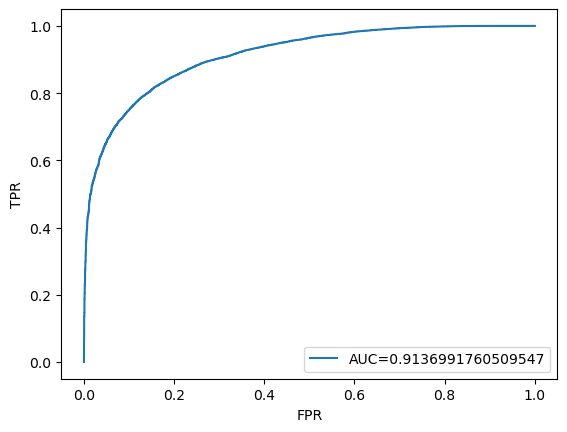

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,clf__C,mean_test_score,std_test_score
0,0.5,0.785704,0.008124
1,1.0,0.779319,0.008604
2,2.0,0.773948,0.008930


SVM
accuracy 0.8552879509404228
f1_macro 0.7857517127443863


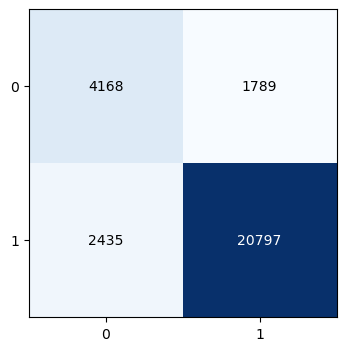

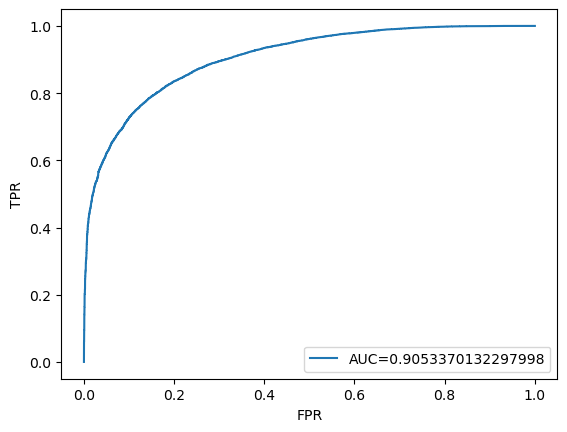

In [8]:
def load_data_last():
    tr = pd.read_csv("train1.csv").drop_duplicates()
    te = pd.read_csv("test1.csv").drop_duplicates()
    for df in (tr, te):
        df["reviewText"] = mark_negations(clean_series(df["reviewText"]))
        df["summary"] = mark_negations(clean_series(df["summary"]))
        df["category"] = df["category"].astype(str).fillna("")
    y = (tr["overall"] > 1).astype(int).values
    ids = te["id"].tolist()
    X_tr = tr[["reviewText", "summary", "category"]].copy()
    X_te = te[["reviewText", "summary", "category"]].copy()
    return X_tr, X_te, y, ids

def vectoriser_last():
    return ColumnTransformer(
        transformers=[
            ("review", TfidfVectorizer(max_features=60000, ngram_range=(1, 2), stop_words="english", min_df=3, sublinear_tf=True), "reviewText"),
            ("summary", TfidfVectorizer(max_features=15000, ngram_range=(1, 1), stop_words="english", min_df=2, sublinear_tf=True), "summary"),
            ("category", TfidfVectorizer(analyzer="char", ngram_range=(3, 5), min_df=1), "category"),
        ],
        remainder="drop",
        sparse_threshold=0.3
    )

def build_pipelines_last():
    vec = vectoriser_last()
    pipe_nb = Pipeline([("vec", vec), ("clf", MultinomialNB())])
    pipe_lr = Pipeline([("vec", vec), ("clf", LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=2000))])
    pipe_svm = Pipeline([("vec", vec), ("clf", LinearSVC(class_weight="balanced", max_iter=3000))])
    grids = {
        "NB": {"clf__alpha": [0.1, 0.5, 1.0]},
        "LR": {"clf__C": [0.5, 1.0, 2.0]},
        "SVM": {"clf__C": [0.5, 1.0, 2.0]}
    }
    return {"NB": pipe_nb, "LR": pipe_lr, "SVM": pipe_svm}, grids

if __name__ == "__main__":
    X_tr, X_te, y, ids = load_data_last()
    best_model = run_cv(build_pipelines_last, X_tr, y)
    preds = best_model.predict(X_te)
    pd.DataFrame({"id": ids, "overall": preds}).to_csv("test1_output3.csv", index=False)